## 1. Introduction

In this project, I analyze environmental farming data before building a predictive model that will recommend suitable crops to plant depending on a given set of farming conditions to optimize agriculture production.

The variables in the dataset are:
- **N** - ratio of Nitrogen content in the soil
- **P** - ratio of Phosphorus content in the soil
- **K** - ratio of Potassium content in the soil
- **Temperature** - temperature in Celsius
- **Humidity** - relative humidity in %
- **pH** - pH value of the soil
- **Rainfall** - rainfall in mm
- **Label** - type of crop

The NPK ratios were synthetically generated while temperature, humidity, pH, and ranfall data originated from India. More information about the dataset can be found at [https://github.com/Gladiator07/Harvestify](https://github.com/Gladiator07/Harvestify).

### 1.1 Importing Packages

These are the packages I used for this project.

In [1]:
# Import packages used in this project
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### 1.2 Viewing the Data

Before visualizing the data, I examined the structure of the dataset:

- There are 2,200 rows and 8 variables
- There are no missing values or duplicated records
- All variables except for crop type are numeric
- There are 22 different types of crops with 100 records for each type

In [2]:
# Import the data
df = pd.read_excel('data/data.xlsx')

In [3]:
# Preview the data
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [4]:
# View structure of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [5]:
# Check for duplicate values
df.duplicated().sum()

0

In [6]:
# View list of crops
df['label'].unique()

array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate',
       'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple',
       'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'],
      dtype=object)

In [7]:
# View value counts of each crop
df['label'].value_counts()

pomegranate    100
pigeonpeas     100
coconut        100
mango          100
banana         100
mothbeans      100
maize          100
jute           100
grapes         100
cotton         100
orange         100
chickpea       100
apple          100
mungbean       100
coffee         100
kidneybeans    100
muskmelon      100
blackgram      100
watermelon     100
lentil         100
papaya         100
rice           100
Name: label, dtype: int64

Next, I looked at the numerical summary of the data. Nitrogen, phosphorus, and potassium content in the soil have similar means from 48.1 - 53.4, but potassium has a high variability with a standard deviation of 50.6. Rainfall also has a high variability with a standard deviation of 55.0 mm.

In [8]:
# View summary statistics of the data
df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


I looked at the mean and median values of each variable by crop. Some crops have a similar mean value for some variables but different for others. Thus, it’s important to consider all environmental factors before planting to see if the crop is suitable.

In [9]:
# View mean values by crop
df.groupby('label').mean()

,N,P,K,temperature,humidity,ph,rainfall
label,,,,,,,
apple,20.80,134.22,199.89,22.630942,92.333383,5.929663,112.654779
banana,100.23,82.01,50.05,27.376798,80.358123,5.983893,104.626980
blackgram,40.02,67.47,19.24,29.973340,65.118426,7.133952,67.884151
chickpea,40.09,67.79,79.92,18.872847,16.860439,7.336957,80.058977
coconut,21.98,16.93,30.59,27.409892,94.844272,5.976562,175.686646
coffee,101.20,28.74,29.94,25.540477,58.869846,6.790308,158.066295
cotton,117.77,46.24,19.56,23.988958,79.843474,6.912675,80.398043
grapes,23.18,132.53,200.11,23.849575,81.875228,6.025937,69.611829
jute,78.40,46.86,39.99,24.958376,79.639864,6.732778,174.792798


In [10]:
# View mean values by crop
df.groupby('label').median()

,N,P,K,temperature,humidity,ph,rainfall
label,,,,,,,
apple,24.0,136.5,200.0,22.628290,92.416541,5.885818,112.979230
banana,100.5,81.0,50.0,27.443333,80.223599,5.994462,105.007750
blackgram,41.0,67.0,19.0,29.655515,65.026723,7.165240,68.293539
chickpea,39.0,68.0,79.0,18.878291,16.658634,7.356537,79.692282
coconut,24.0,15.5,31.0,27.385317,94.960581,5.990709,171.999922
coffee,103.0,29.0,30.0,25.656643,57.648083,6.798626,157.770963
cotton,117.0,46.0,19.0,23.964997,80.010893,6.840957,80.237095
grapes,24.0,133.0,201.0,23.018528,81.724647,6.001785,69.536186
jute,78.0,46.0,40.0,24.971106,79.469205,6.711500,175.590814


## 2. Exploratory Data Analysis

Now that I have an idea of the contents of the dataset, I can now visualize the data to look for patterns.

I set some formatting parameters below.

In [11]:
# Set plot formatting for consistency
sns.set_style('whitegrid')
sns.set_context("talk", font_scale = 1)

# Set data frame formatting
pd.options.display.float_format = '{:,.2f}'.format

### 2.1 Distributions of the Data

I plotted the distributions of the variables in the dataset.

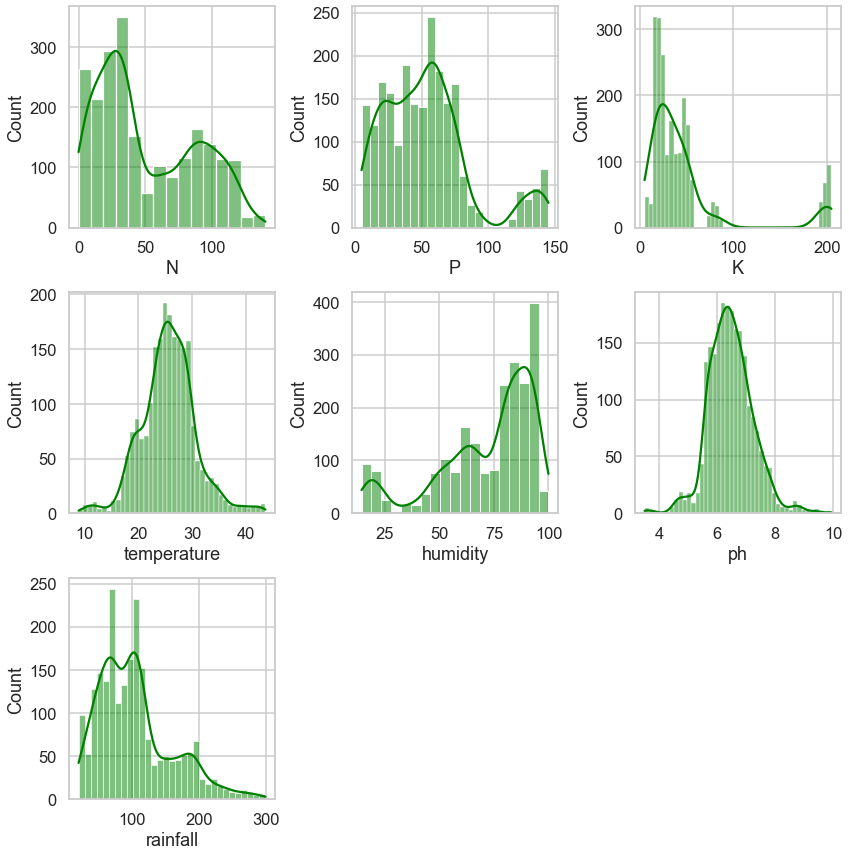

In [12]:
# Plot distributions of the variables
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12,12))

sns.histplot(data=df, x="N", kde=True, color='green', ax=axs[0, 0])
sns.histplot(data=df, x="P", kde=True, color='green', ax=axs[0, 1])
sns.histplot(data=df, x="K", kde=True, color='green', ax=axs[0, 2])
sns.histplot(data=df, x="temperature", kde=True, color='green', ax=axs[1, 0])
sns.histplot(data=df, x="humidity", kde=True, color='green', ax=axs[1, 1])
sns.histplot(data=df, x="ph", kde=True, color='green', ax=axs[1, 2])
sns.histplot(data=df, x="rainfall", kde=True, color='green', ax=axs[2, 0])
fig.delaxes(axs[2,1])
fig.delaxes(axs[2,2])

fig.tight_layout()
plt.savefig('images/dist_plots.png')

The nitrogen, phosphorus, and potassium content in the soil, as well as rainfall, are right skewed while humidity is left skewed. Temperature and pH are approximately normally distributed.

Next, I plotted the scatterplot matrix of the data to see relationships between the variables.

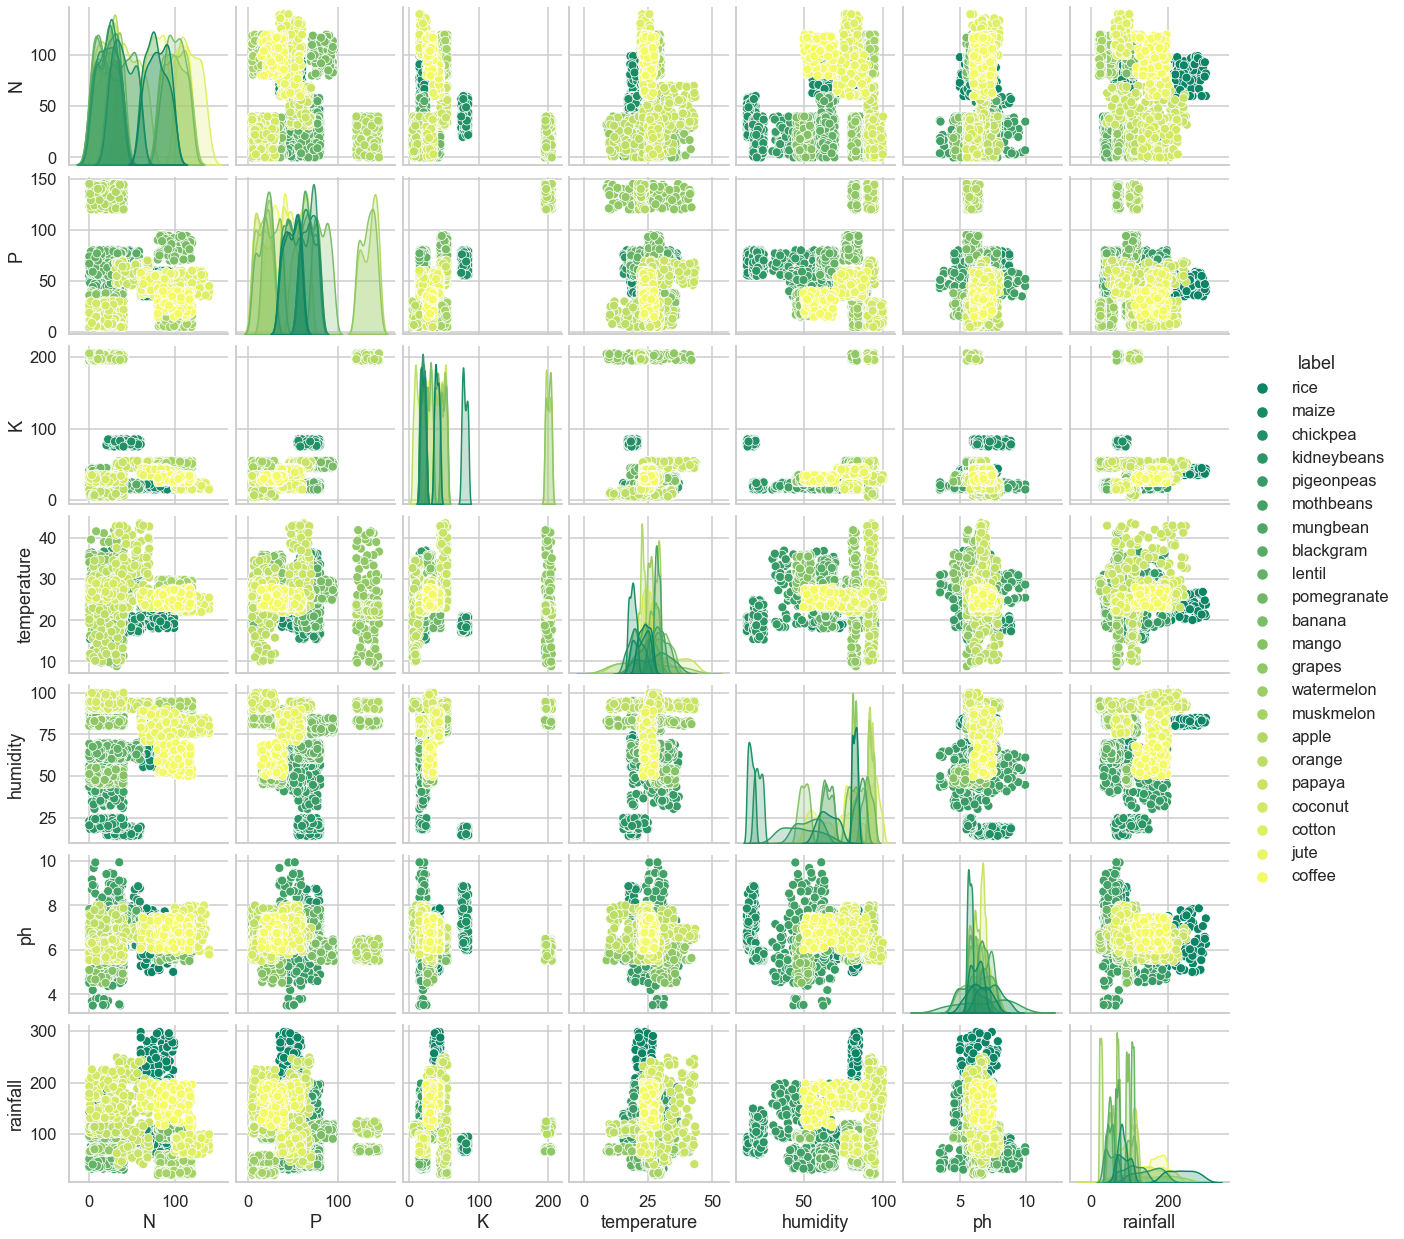

In [13]:
# Plot scatterplot matrix of the variables
sns.pairplot(df, hue = 'label', palette='summer')
plt.savefig('images/pairplot.png')

Since there are 7 variables in the data, the graphs are a little bit difficult to see. However, there are some visible clusters of crops among the plots.

I plotted a heatmap of the correlation matrix to aid with the visualization.

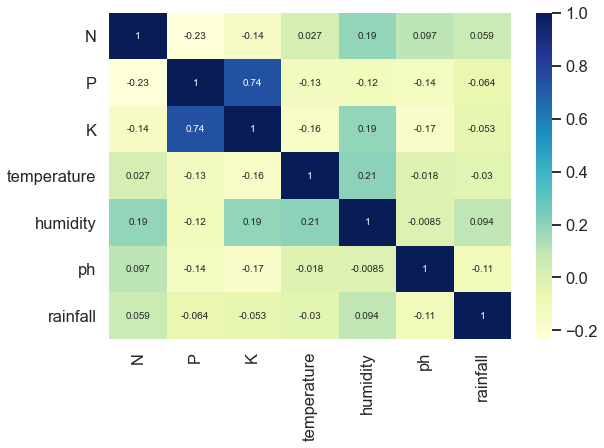

In [14]:
# View correlation matrix of the data
plt.figure(figsize = (9, 6))
sns.heatmap(df.corr(), cmap = 'YlGnBu', annot = True)
plt.savefig('images/correlation_plot.png')

There is a fairly strong, positive, linear relationship between the phosphorus and potassium content in the soil. The remaining variable pairs appear to have no linear relationship or have a very weak one.

### 2.2 Nitrogen

I will now examine how each crop is distributed for each variable one by one.

I defined a function that will plot a boxplot of a specified variable for each crop type.

In [15]:
# Define function to plot a boxplot of a variable for each crop
def plot_crops(df, var, label):
    
    plt.figure(figsize=(24,9), dpi = 120)
    plt.xticks(rotation=45)
    
    ax = sns.boxplot(y=var, x='label', data=df, palette='summer_r', order=df.groupby('label')[var].median().sort_values().index)
    ax = sns.stripplot(y=var, x='label', data=df, palette='summer_r', linewidth=1, order=df.groupby('label')[var].median().sort_values().index)
    ax.set(xlabel='Crop', ylabel=label)
    
    plt.savefig('images/' + var + '_plot.png', bbox_inches='tight')

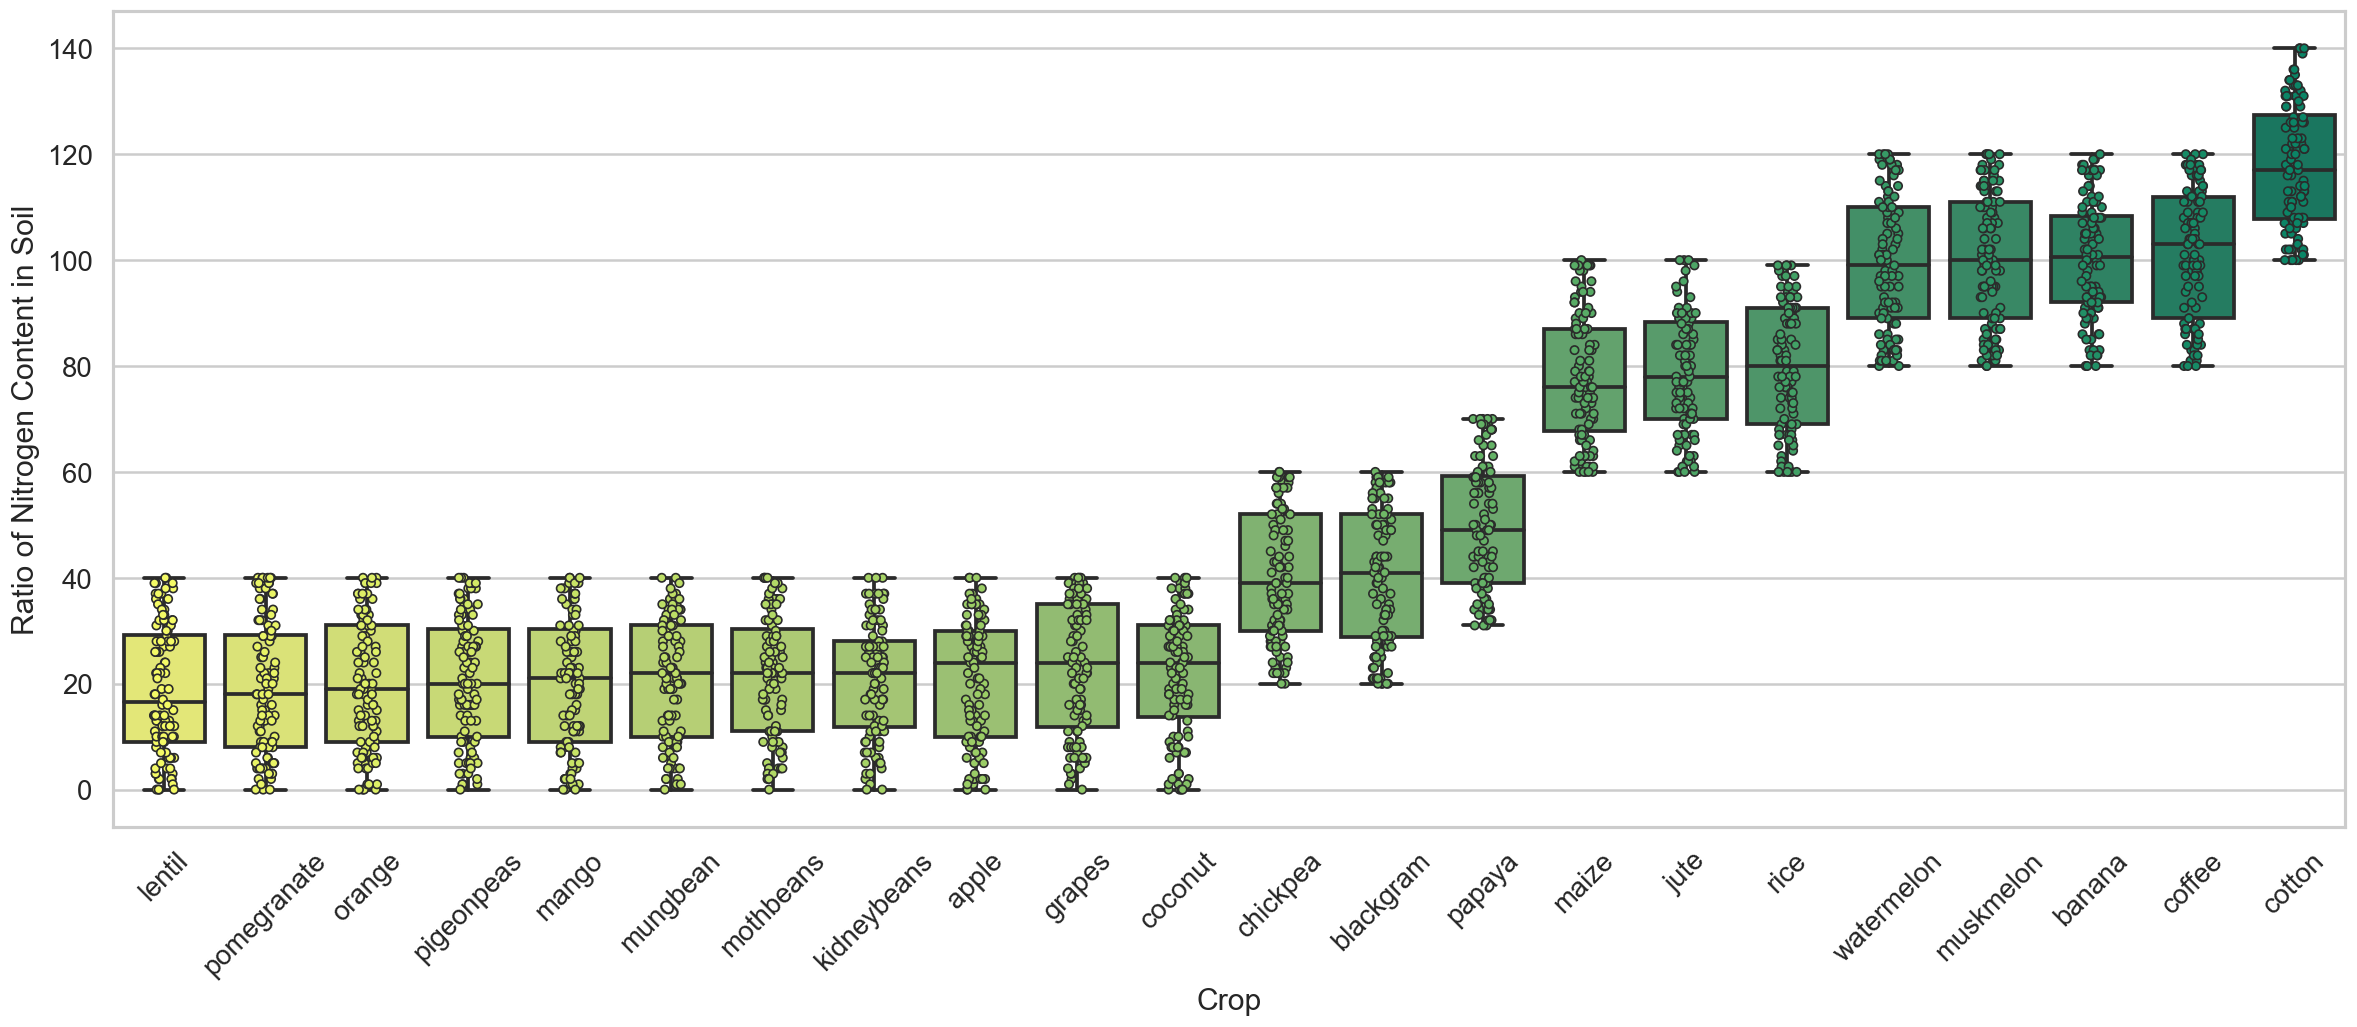

In [16]:
# Plot boxplot of Nitrogen
plot_crops(df, 'N', 'Ratio of Nitrogen Content in Soil')

Each crop has almost the same variability in the ratio of nitrogen content with the standard deviation ranging from 10.8 - 12.7. The distributions of the nitrogen content are the same for the crops below with the following medians:

1. Median N ~20: lentil, pomegranate, orange, pigeon peas, mung bean,  moth beans, kidney beans, apple, grape, coconut
2. Median N ~40: black gram, chickpea
3. Median N ~80: maize, jute, rice
4. Median N ~100: watermelon, muskmelon, banana, coffee

Papaya and cotton differ from the rest of the crops with medians of 49.0 and 117.0, respectively.

### 2.3 Phosphorus

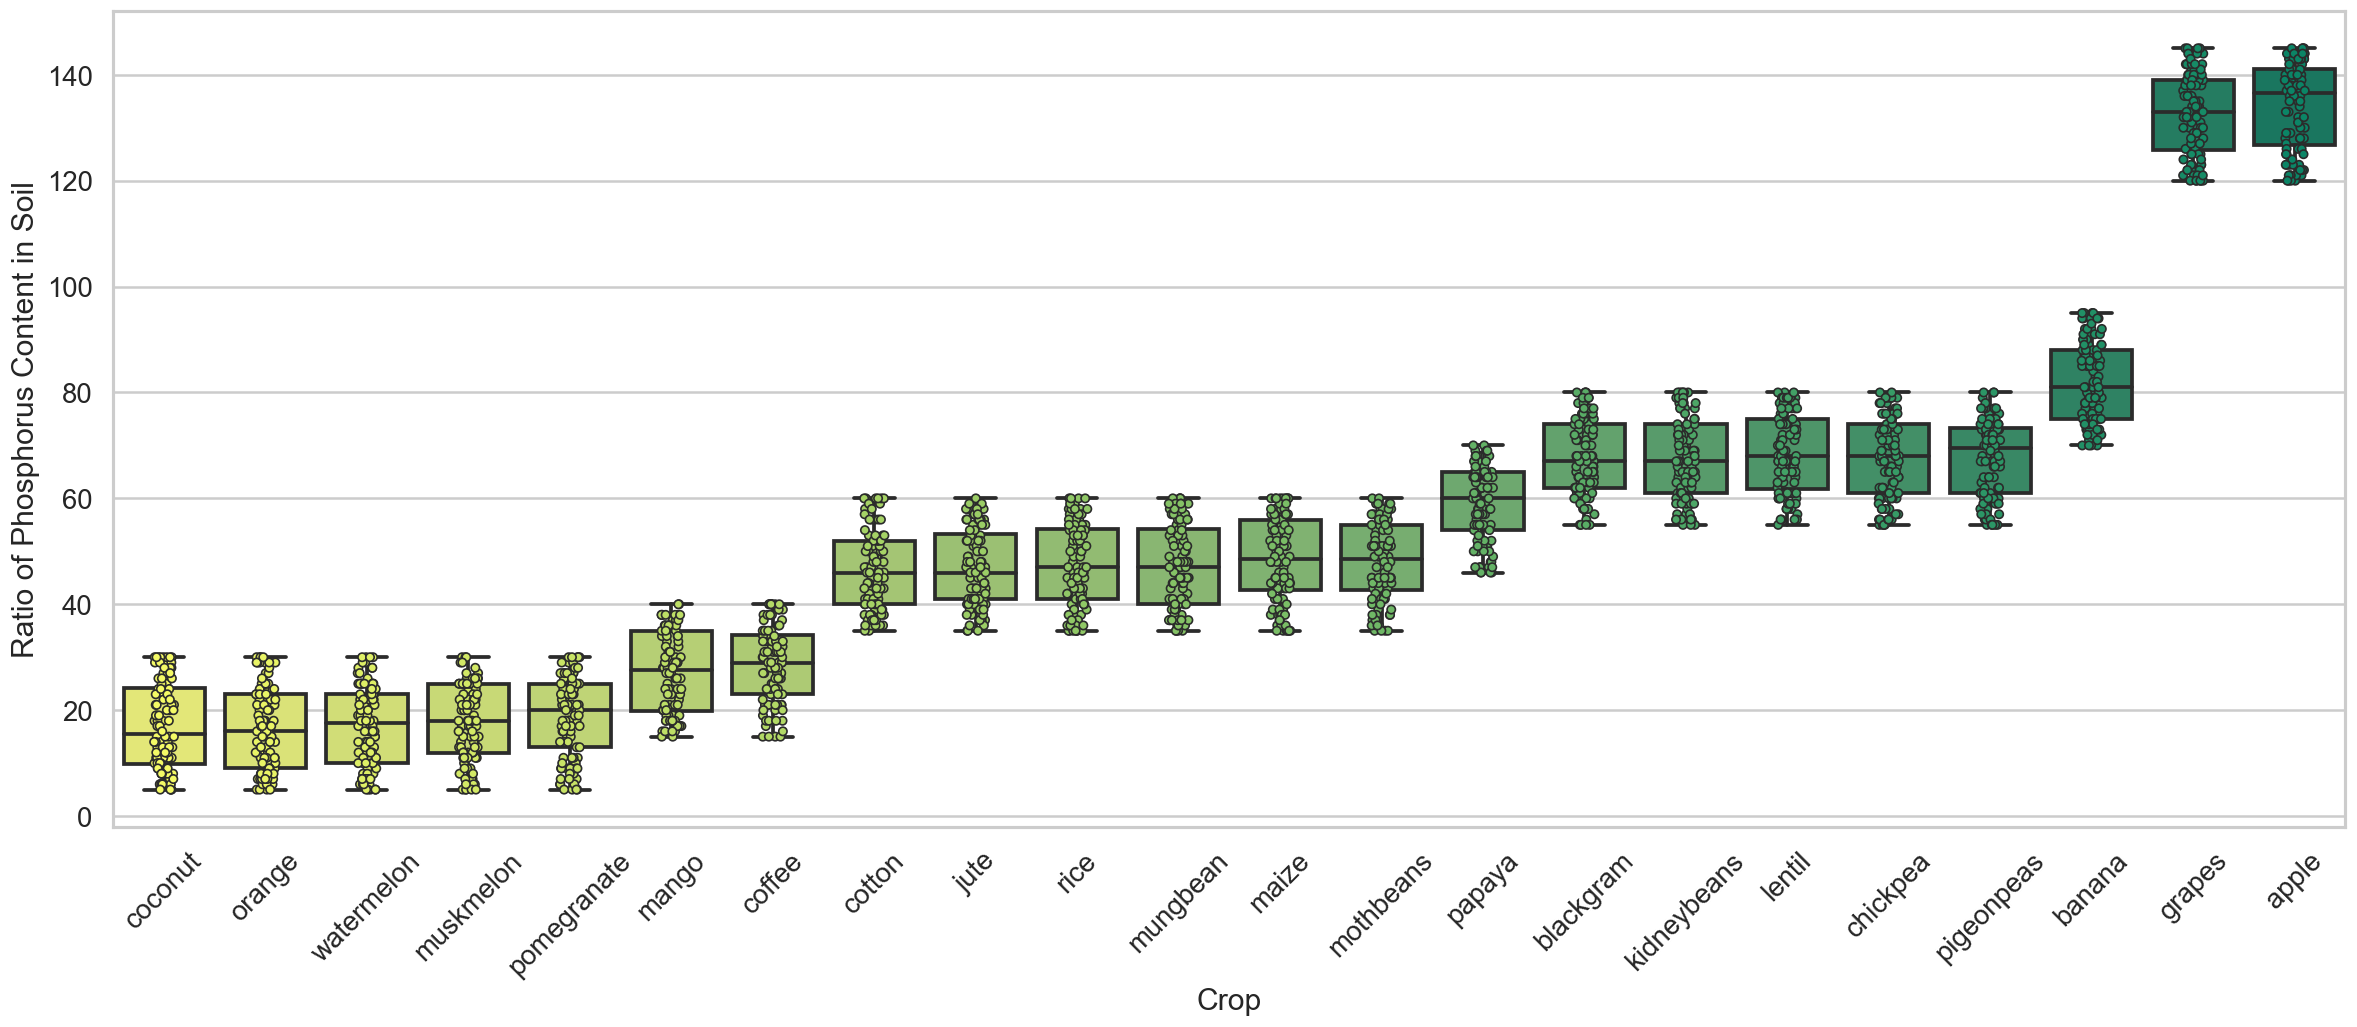

In [17]:
# Plot boxplot of Phosphorous
plot_crops(df, 'P', 'Ratio of Phosphorus Content in Soil')

Each crop has almost the same variability in the ratio of phosphorus content with the standard deviation ranging from 7.1 - 8.4. The distributions of the phosphorus content are the same for the crops below with the following medians:

1. Median P ~20: coconut, orange, watermelon, muskmelon, pomegranate
2. Median P ~30: mango, coffee
3. Median P ~50: cotton, jute, rice, mung bean, maize, moth beans, 
4. Median P ~70: black gram, kidney beans, lentil, chickpea, pigeon peas
5. Median P ~130: grapes, apple

Papaya and banana differ from the rest of the crops with medians of 60.0 and 81.0, respectively.

### 2.4 Potassium

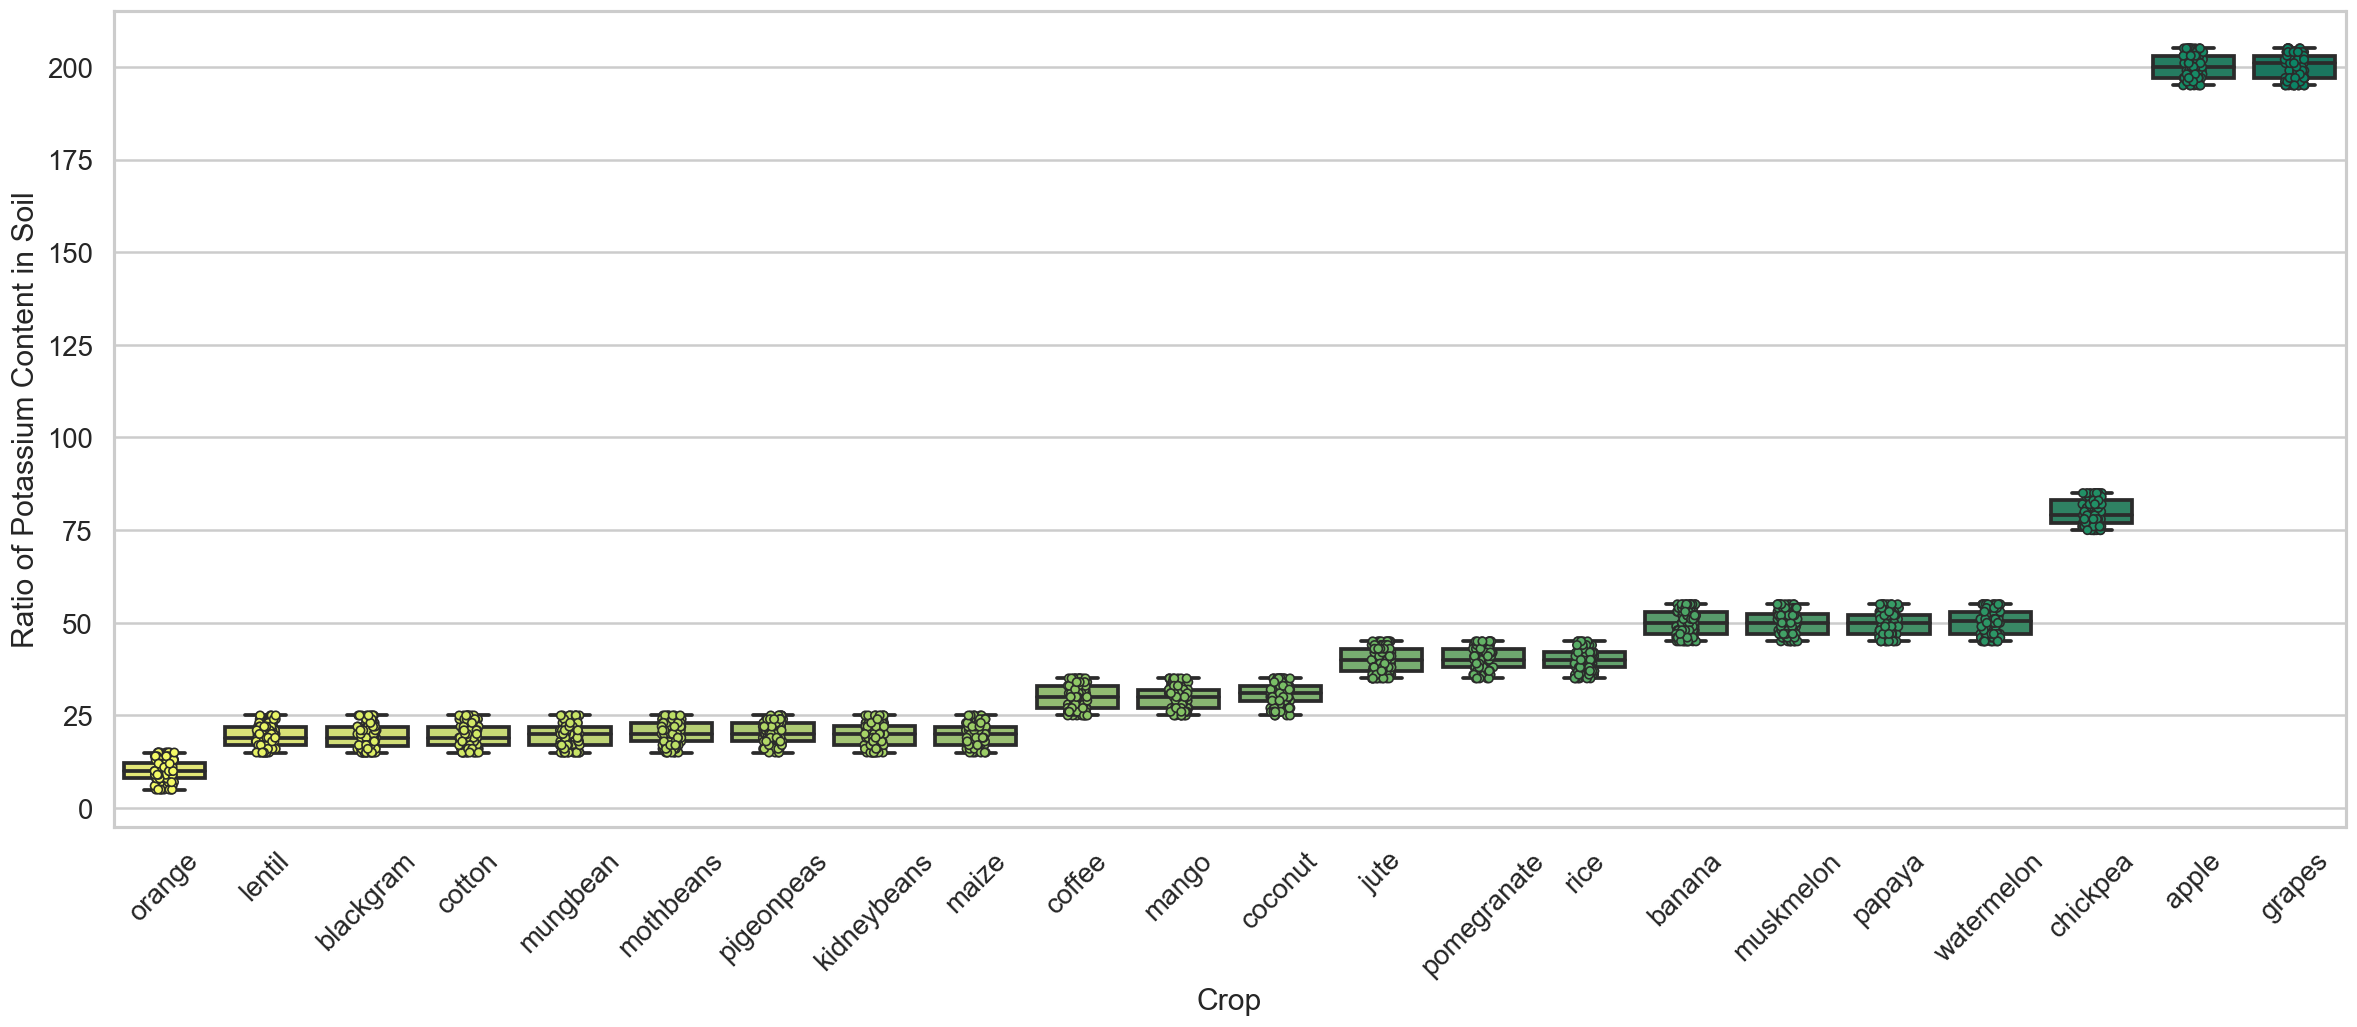

In [18]:
# Plot boxplot of Potassium
plot_crops(df, 'K', 'Ratio of Potassium Content in Soil')

Although potassium had the highest overall variability, the variability for each crop is very small with standard deviations ranging from 2.8 - 3.4. The distributions of the potassium content are the same for the crops below with the following medians:

1. Median K ~20: lentil, black gram, cotton, mung bean, moth beans, pigeon peas, kidney beans, maize
2. Median K ~30: coffee, mango, coconut
3. Median K ~40: jute, pomegranate, rice
4. Median K ~50: banana, muskmelon, papaya, watermelon
5. Median K ~200: apple, grapes


Orange and chickpea differ from the rest of the crops with medians of 10.0 and 79.0, respectively.

### 2.5 Temperature

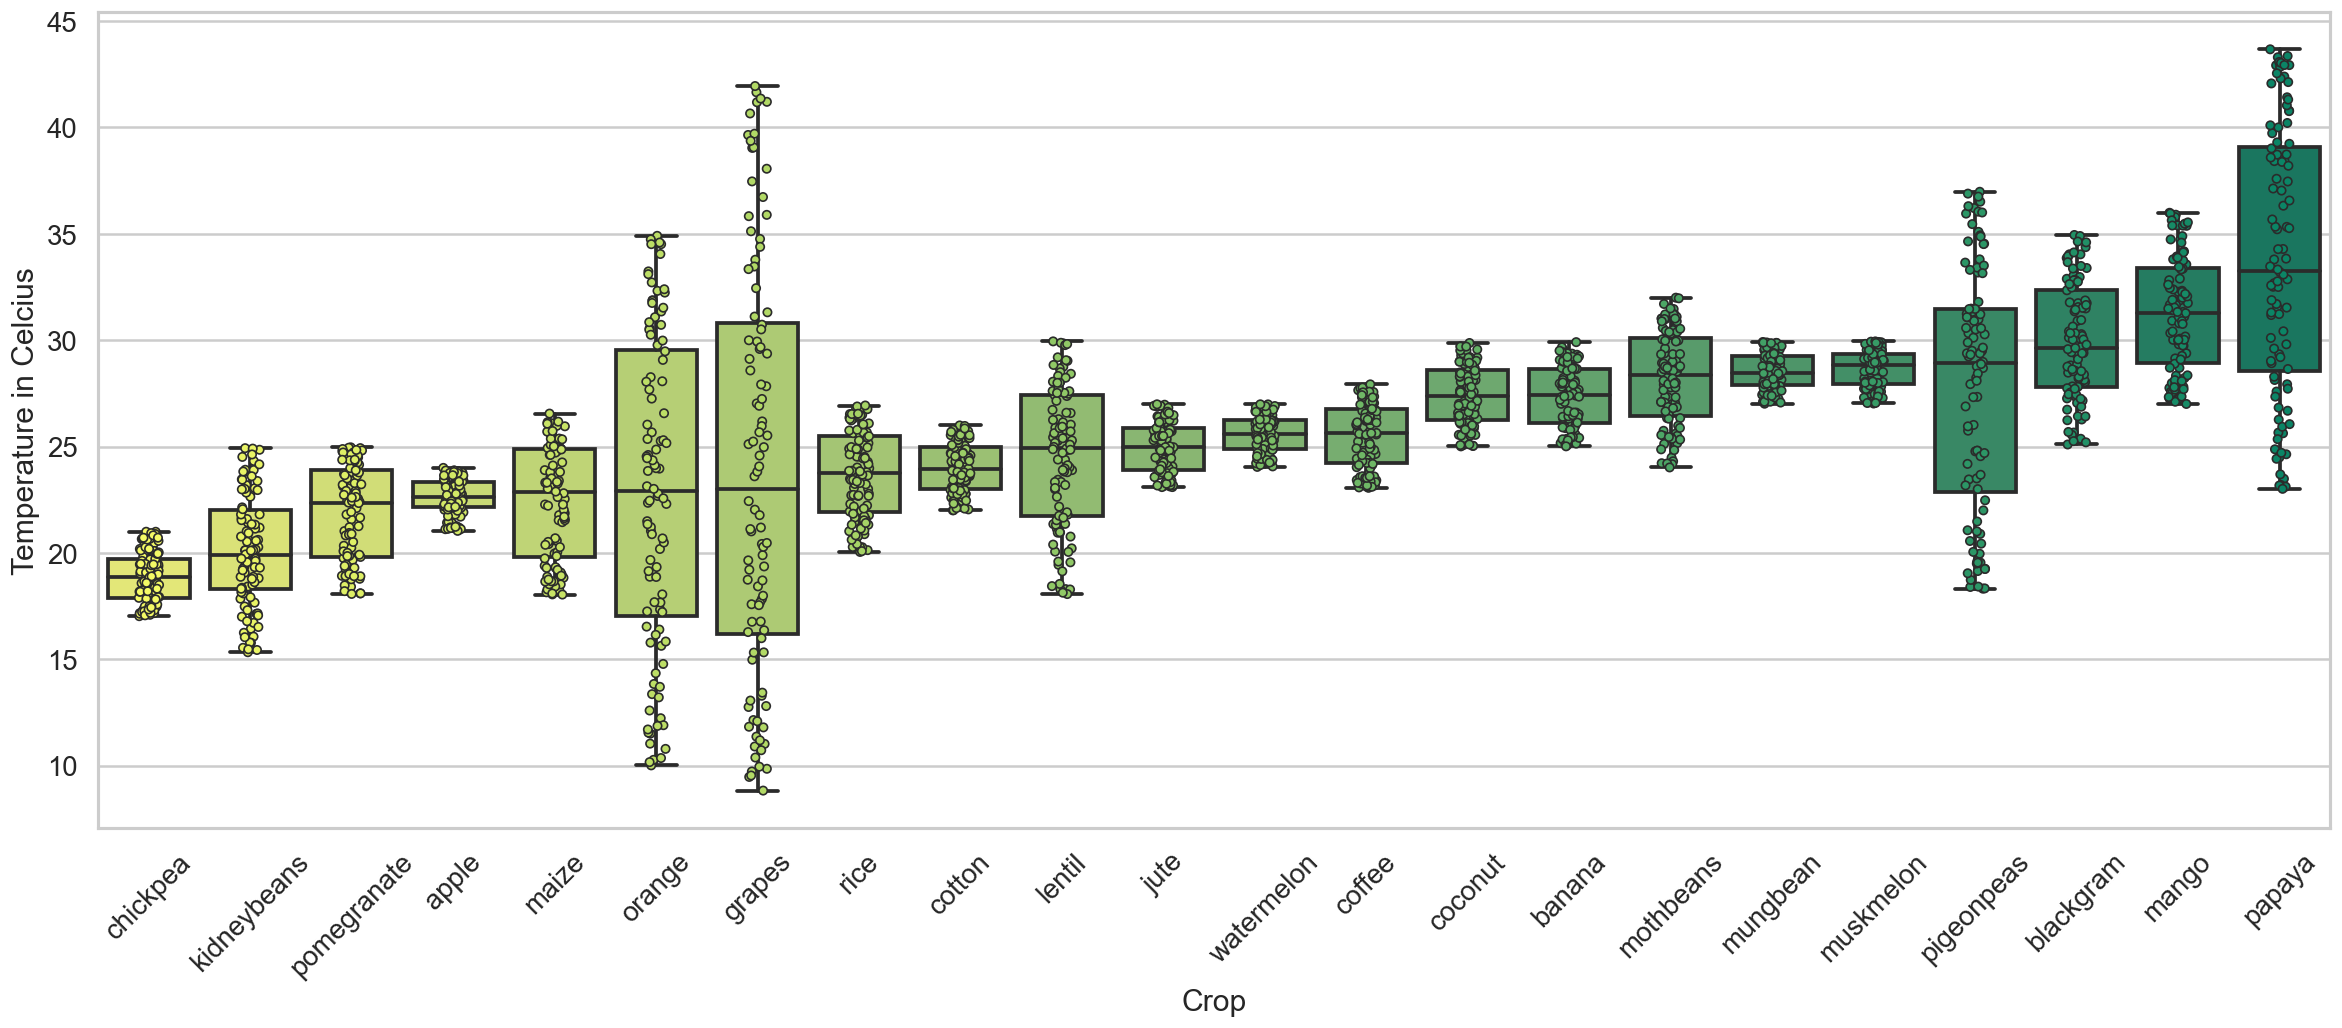

In [19]:
# Plot boxplot of temperature
plot_crops(df, 'temperature', 'Temperature in Celcius')

The majority of crops have a relatively small variability in temperature with grapes, oranges, papayas, and pigeon peas having a larger variability. Median temperatures vary from ~19.0 to ~33.0 degrees Celsius.

### 2.6 Humidity

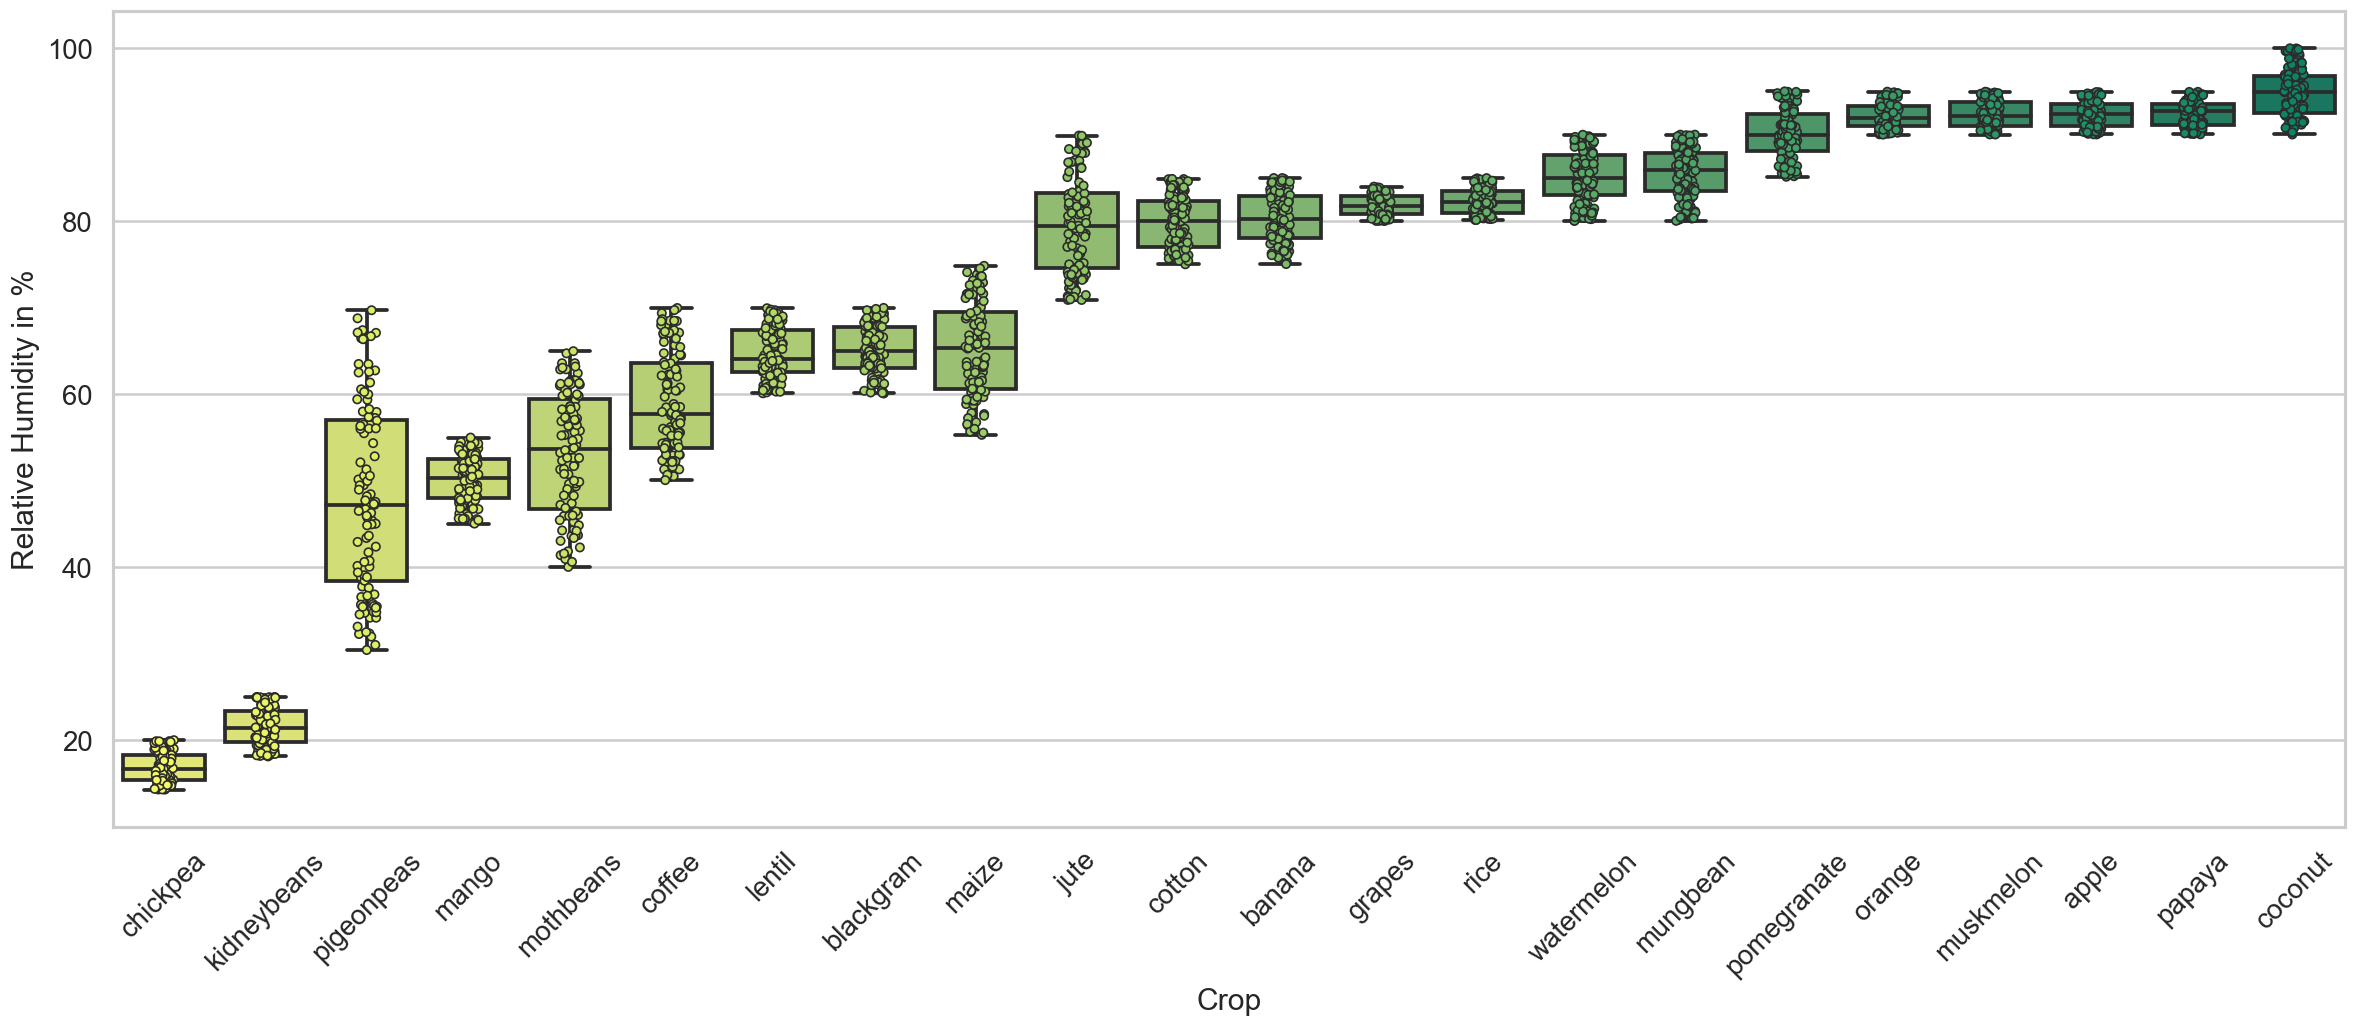

In [20]:
# Plot boxplot of humidity
plot_crops(df, 'humidity', 'Relative Humidity in %')

The majority of crops have a relatively small variability in humidity with pigeon peas and moth beans having the largest variability. Median values for the relative humidity vary from ~17.0% to ~95.0%. The majority of crops have a relative humidity greater than 80%. 

### 2.7 pH

In [ ]:
# Plot boxplot of pH
plot_crops(df, 'ph', 'pH Level of Soil')

Just like temperature and humidity, the majority of crops have a relatively small variability in pH content with the exception of moth beans, which have a pH range of 3.5 to 10.0. The median pH content ranges from ~5.7 to ~7.4.

### 2.8 Rainfall

In [ ]:
# Plot boxplot of rainfall
plot_crops(df, 'rainfall', 'Rainfall (mm)')

Some crops have a small variability while others like papaya have a very large variability. Median rainfall ranges from around 25mm to 230mm. Crops that have a larger median rainfall tend to have higher variability as well.

## 3. Clustering Crops

The boxplots showed that some crops share similar environmental conditions as others. Thus, it would be practical to plant these crops together. One way to determine which crops to plant together is by performing a clustering algorithm on the data to group crops that share similar conditions with each other.

### 3.1 K-Means Clustering

A popular clustering algorithm is the **K-Means Clustering** algorithm, which divides the data into *k* distinct clusters. The algorithm is as follows:

1. Randomly assign each observation to a cluster.
2. For each cluster, calculate the *centroid*, which is the mean vector of the features of the observations in that cluster.
3. Assign each observation to the closest centroid using the Euclidean distance.
4. Repeat steps 2 - 3 until the cluster assignments no longer change. 

Since all the features in the data are numeric, k-means clustering is an appropriate algorithm to use.

In [ ]:
# Get X values
X = df.drop('label', axis=1)

# Scale the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

Since the features are measured in different units, I used the MinMaxScaler to scale the data to values between 0 and 1. 

Now, I need to determine the number of clusters to use, *k*. One way to determine the optimal *k* values is to minimize the *within-cluster variation*, which is the average amount that the observations in a cluster differ from each other. In this case, we will use the Euclidean distance to measure the within-cluster variation.

The within-cluster variation decreases as the number of *k* increases, so we will select the *k* where the decrease in the within-cluster variation stops being significant.

In [ ]:
# Initialize empty list to store within-cluster variation
wcv = []

# Fit K-Means clustering with 1 - 15 clusters and collect within-cluster variation
for k in range(1, 16):

    kmeans = KMeans(n_clusters=k, random_state=1)
    cluster_fit = kmeans.fit(X_scaled)
    wcv.append(cluster_fit.inertia_)

In [ ]:
# Plot within-cluster variation against number of clusters to determine optimal number of clusters to use
plt.figure(figsize = (12, 9))
plt.plot(range(1, 16), wcv)
plt.title('Within-Cluster Variation vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Variation')
plt.savefig('images/elbow.png')

I measured the within-cluster variation for 1 to 15 clusters and plotted them in the graph above. Based on the plot, having 4 clusters results in a relatively low within-cluster variation, but having more than 4 no longer decreases the variation by a significant amount. This method of determining the number of clusters is known as the **elbow** method.

Thus, the optimal number of clusters for this data is 4, which I fit below.


In [ ]:
# Fit K-Means clusters with k = 4 clusters
kmeans = KMeans(n_clusters=4, random_state=1)
cluster_fit = kmeans.fit(X_scaled)

### 3.2 Clustering Results

The results of the k-means clustering algorithm are shown below. The majority of crops were classified into a single cluster except for papaya, pigeon peas, and maize. 

Overall, the crops were classified to the following clusters:

- **Cluster 1**: watermelon, cotton, coffee, banana, jute, rice, muskmelon, maize
- **Cluster 2**: lentil, moth beans, chickpea, kidney beans, mango, black gram, pigeon peas
- **Cluster 3**: grapes, apple
- **Cluster 4**: pomegranate, mung bean, orange, coconut, papaya 

In [ ]:
# Obtain cluster labels for each record
df['cluster_labels'] = cluster_fit.labels_

In [ ]:
# Calculate the number of crops classified in each cluster
for i in range(0,4):
    print(df[df['cluster_labels'] == i]['label'].value_counts())

Next, I looked at the mean and median of each variable for each cluster. Then, I plotted the boxplots of the variables for each cluster.

In [ ]:
# View mean values for each cluster
df.groupby('cluster_labels').mean()

In [ ]:
# View median values for each cluster
df.groupby('cluster_labels').median()

In [ ]:
# Plot boxplots of each variable for each cluster
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12,12))

sns.boxplot(x='cluster_labels', y='N', data=df, ax=axs[0, 0], palette='Paired')
sns.boxplot(x='cluster_labels', y='P', data=df, ax=axs[0, 1], palette='Paired')
sns.boxplot(x='cluster_labels', y='K', data=df, ax=axs[0, 2], palette='Paired')
sns.boxplot(x='cluster_labels', y='temperature', data=df, ax=axs[1, 0], palette='Paired')
sns.boxplot(x='cluster_labels', y='humidity', data=df, ax=axs[1, 1], palette='Paired')
sns.boxplot(x='cluster_labels', y='ph', data=df, ax=axs[1, 2], palette='Paired')
sns.boxplot(x='cluster_labels', y='rainfall', data=df, ax=axs[2, 0], palette='Paired')
fig.delaxes(axs[2,1])
fig.delaxes(axs[2,2])

fig.tight_layout()
plt.savefig('images/cluster_plots.png')

Overall, I made the following observations:

- Cluster 1 is characterized by a large ratio of nitrogen content in the soil.
- Cluster 2 is characterized by a moderate ratio of phosphorus content and low humidity.
- Cluster 3 is characterized by a large ratio of phosphorus and potassium content in the soil.

## 4. Crop Prediction

Based on the results of the k-means clustering algorithm, we have an idea of which crops are best planted together based on requiring similar environmental conditions. Now, I will build a predictive model that will determine which crop to plant based on a given set of environmental conditions. 

### 4.1 Random Forest Model

Since the response variable has 22 different possible options, I decided to use a tree-based algorithm for my model. A popular tree-based algorithm is the **Random Forest** model due to its ability to include many features while avoiding overfitting. The algorithm involves building a number of decision trees on bootstrapped training samples but only considering a random selection of the predictors when splitting to decorrelate the trees.

I split my data into a training and testing set. The training set will be used to build the random forest model while the testing set will be used to measure the model's performance.

In [ ]:
# Get array of y values
y = df['label']

# Split the dataset into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

I fit a random forest with *n* = 200 trees on the training set.

In [ ]:
# Initialize random forest model
rfc = RandomForestClassifier(n_estimators=200)

# Fit random forest model
rfc.fit(X_train, y_train)

### 4.2 Model Results

I used the testing set to calculate the performance of the random forest model. The model did very well in classifying the crops with almost perfect accuracy. There were some misclassifications for jute and rice.

In [ ]:
# Calculate model performance
rfc_pred = rfc.predict(X_test)
print(classification_report(y_test, rfc_pred))

A heatmap of the confusion matrix is shown below. 

In [ ]:
# View confusion matrix
plt.figure(figsize = (15, 12))
cf = confusion_matrix(y_test, rfc_pred)
sns.heatmap(cf, cmap='summer_r', annot=True)
plt.savefig('images/confusion_matrix.png')

### 4.3 Model Prediction

The random forest model can be used to predict a suitable crop to plant given a new set of conditions. For example, when taking the mean values of all the variables in the entire dataset and inputting it into the model, the model predicts that papaya would be the best crop to plant.

In [ ]:
# View means values of the variable
df.mean()

In [ ]:
# Use the model to predict a crop given the following conditions
rfc.predict((np.array([[51, 54, 48, 26, 71, 6.5, 103]])))

## 5. Conclusion

The k-means clustering algorithm did well in determining which crops share similar environmental conditions for growth while the random forest model did well in predicting suitable crops to plant based on a given set of conditions.

The dataset used in this analysis might not be representative of farming conditions around the world. However, the process might still be useful for **precision agriculture**, where data about the environment and crops are collected to determine how, when, where, etc. to plant a specific crop for maximum growth and yield. It can also be used to determine variability within plots. Overall, this process has the potential to increase farming efficiency and yield.